# 1. Import the data

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')

# Get historical data for BTC/USD and FXS/USD
BTC = pd.read_csv('BTC-USD.csv', index_col=0)
FXS = pd.read_csv('FXS-USD.csv', index_col=0)

# Create a dataframe df and store the closing price of BTC/USD and FXS/USD in a column name BTC and FXS respectively.
df = pd.DataFrame({'BTC': BTC.Close, 'FXS': FXS.Close})
df.tail(10)

,BTC,FXS
Date,,
2022-12-07,16848.126953,5.738633
2022-12-08,17233.474609,6.009667
2022-12-09,17133.152344,6.115902
2022-12-10,17128.724609,6.051961
2022-12-11,17104.193359,5.844939
2022-12-12,17206.437500,5.668530
2022-12-13,17781.318359,5.648585
2022-12-14,17815.650391,5.693855
2022-12-15,17364.865234,5.481434


# 2. Calculate the hedge ratio

In [188]:
# Import statsmodels package
import statsmodels.api as sm

# Create and fit the linear model
reg = sm.OLS(df.BTC.iloc[:90], df.FXS.iloc[:90]).fit()

# Extract the parameter
hedge_ratio = reg.params[0]
print("Hedge Ratio = ", hedge_ratio)

Hedge Ratio =  3851.627990523863


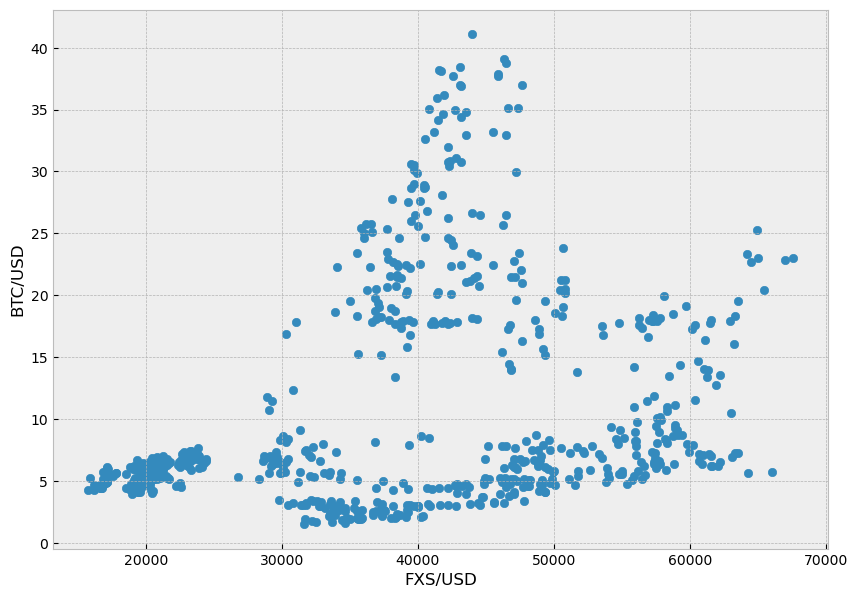

In [189]:
# Plot the scatter graph
plt.figure(figsize=(10, 7))
plt.scatter(df['BTC'], df['FXS'])
plt.xlabel("FXS/USD")
plt.ylabel("BTC/USD")
plt.show()

# 3. Calculate the spread

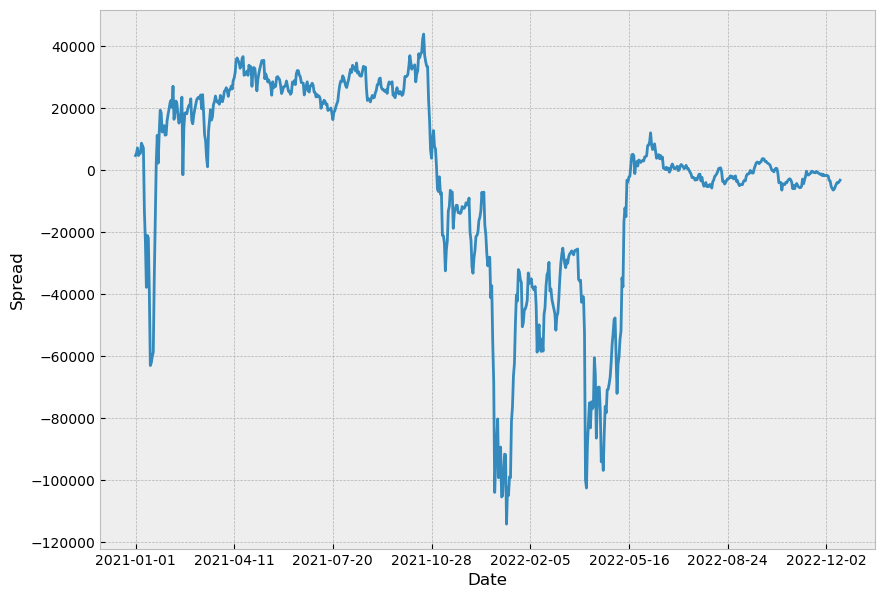

In [190]:
# Calculate the spread
df['spread'] = df.BTC - hedge_ratio * df.FXS

# Plot the Spread
df.spread.plot(figsize=(10, 7))
plt.ylabel('Spread')
plt.show()

# 4. Cointegration Check

In [191]:
import statsmodels.tsa.stattools as ts

# Check cointegration using the adfuller function
coint = ts.adfuller(df.spread.iloc[:90])

print ('test statistic =',coint[0])  
print ('critical value =',coint[4]) 

test statistic = -2.0726112886070536
critical value = {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}


# 5. Bollinger band calculation

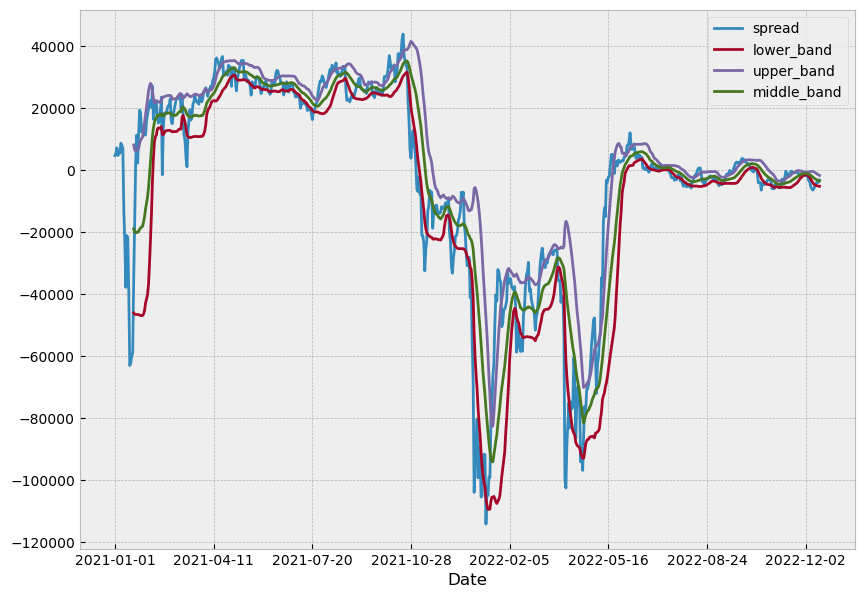

In [192]:
# Calculte Moving Average
df['moving_average'] = df.spread.rolling(20).mean()

# Calculate Moving Standard deviation
df['moving_std_dev'] = df.spread.rolling(20).std()

# Calcuate Upper band, middle band and lower band
df['upper_band'] = df.moving_average + 1 * df.moving_std_dev
df['middle_band'] = df.moving_average
df['lower_band'] = df.moving_average - 1 * df.moving_std_dev

# Plot the Bollinger bands with spread
df[['spread', 'lower_band', 'upper_band', 'middle_band']].plot(figsize=(10, 7))
plt.show()

# 6. Trading signals

In [193]:
# Import numpy
import numpy as np

# Long Entry
df['long_position'] = np.where(df.spread < df.lower_band, 1, 0)

# Long Exit
df['long_position'] = np.where(
    df.spread >= df.middle_band, 0, df.long_position)

# Short Entry
df['short_position'] = np.where(df.spread > df.upper_band, -1, 0)

# Short exit
df['short_position'] = np.where(
    df.spread <= df.middle_band, 0, df.short_position)

# Fill NaN values
df = df.fillna(method='ffill')

# Combine the positions
df['position'] = df.long_position + df.short_position

# Calculate the strategy returns

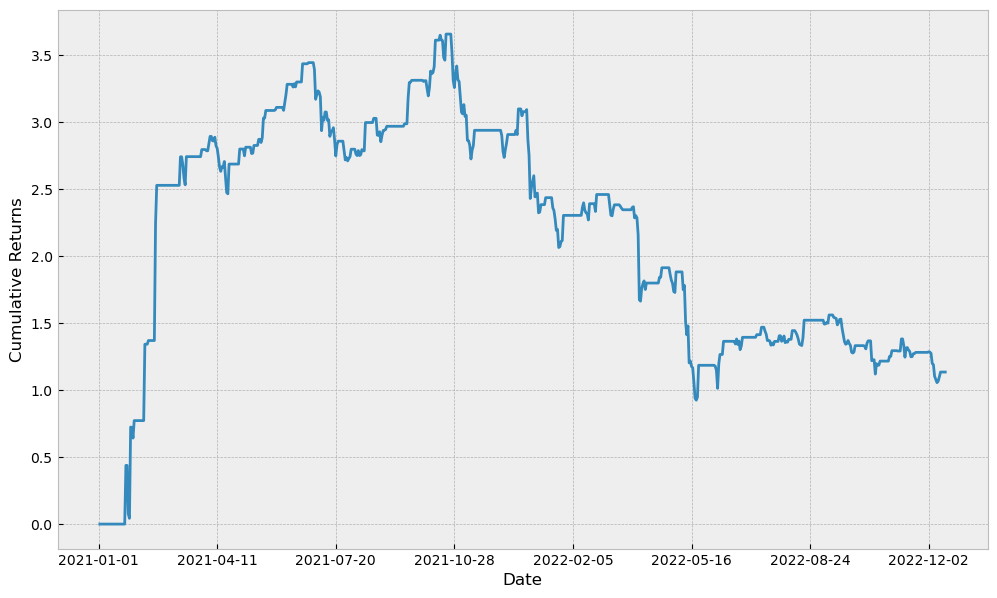

In [194]:
# Daily returns of BTC
df['daily_returns_BTC'] = df.BTC.pct_change()

# Daily returns of FXS
df.FXS = df.FXS * hedge_ratio
df['daily_returns_FXS'] = df.FXS.pct_change()

# Daily Returns
df['daily_returns'] = df.daily_returns_BTC - df.daily_returns_FXS

# Strategy Returns
df['strategy_returns'] = df.position.shift(1) * df.daily_returns

# Plot the strategy returns
df.strategy_returns.cumsum().plot(figsize=(12, 7))
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()